In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, 
import os


In [2]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [3]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
# Data Visualization
import plotly.express as px

In [5]:
import sys
from tqdm import tqdm
import time
import copy

In [6]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [7]:
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Define an image validation function
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # This will raise an exception if the image is invalid
        return True
    except Exception as e:
        return False

def get_data_loaders(data_dir, batch_size, train=False):
    if train:
        # Train
        transform = transforms.Compose([
            # Data augmentation for training, add as needed
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomApply([transforms.ColorJitter()], p=0.25),
            transforms.Resize(438),
            transforms.CenterCrop(384),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "/kaggle/input/all-dataset2-splitted/ALL_Splitted/train/"), transform=transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # Validation and Test
        transform = transforms.Compose([
            transforms.Resize(438),
            transforms.CenterCrop(384),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "/kaggle/input/all-dataset2-splitted/ALL_Splitted/val/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "/kaggle/input/all-dataset2-splitted/ALL_Splitted/test/"), transform=transform)

        # Iterate through the dataset and remove corrupted images
        val_data.samples = [(image, label) for image, label in val_data.samples if is_valid_image(image)]
        test_data.samples = [(image, label) for image, label in test_data.samples if is_valid_image(image)]

        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

        return val_loader, test_loader, len(val_data), len(test_data)

In [ ]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            #T.RandomHorizontalFlip(),
            #T.RandomVerticalFlip(),
            #T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(438),
            T.CenterCrop(384),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
           # T.RandomErasing(p=0.2, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "/kaggle/input/all-dataset2-splitted/ALL_Splitted/train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(438),
            T.CenterCrop(384),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "/kaggle/input/all-dataset2-splitted/ALL_Splitted/val/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "/kaggle/input/all-dataset2-splitted/ALL_Splitted/val/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [8]:
dataset_path = "/kaggle/input/all-dataset2-splitted/ALL_Splitted/"

In [9]:
(train_loader, train_data_len) = get_data_loaders(dataset_path, 128, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

In [10]:
classes = get_classes("/kaggle/input/all-dataset2-splitted/ALL_Splitted/val/")

In [11]:
dataset_path1= "/kaggle/input/all-dataset2-splitted/ALL_Splitted/val/"

# Get Class Names
class_names = sorted(os.listdir(dataset_path1))
n_classes = len(class_names)

# Show
print(f"Class Names : {class_names}")
print(f"Number of Classes  : {n_classes}")

Class Names : ['Benign', 'Early', 'Pre', 'Pro']
Number of Classes  : 4


In [12]:
pred_dataset_path ="/kaggle/input/all-dataset2-splitted/ALL_Splitted/val/"
# Calculate class distribution
class_dis = [len(os.listdir(pred_dataset_path + name)) for name in class_names]

# Visualization
fig = px.pie(names=class_names, values=class_dis, title="Prediction Class Distribution")
fig.update_layout({'title':{'x':0.45}})
fig.show()

In [13]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

In [14]:
print(len(train_loader), len(val_loader), len(test_loader))

16 21 21


In [16]:
print(train_data_len, valid_data_len, test_data_len)

1952 649 655


In [15]:
# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [17]:
## Now, we import timm, torchvision image models
!pip install timm # kaggle doesnt have it installed by default
import timm
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_384', pretrained=True)

Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_384-8de9b5d1.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_384-8de9b5d1.pth
100%|██████████| 331M/331M [00:07<00:00, 44.3MB/s] 


In [18]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

In [ ]:
print(model)

In [19]:
import torch.nn as nn

for param in model.parameters():
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 2048),
    nn.BatchNorm1d(2048),  # Adding batch normalization for regularization
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),  # Increasing dropout rate for stronger regularization
    nn.Linear(2048, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, len(classes))
)
model = model.to(device)
print(model.head)

Sequential(
  (0): Linear(in_features=768, out_features=2048, bias=True)
  (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=2048, out_features=1024, bias=True)
  (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=1024, out_features=512, bias=True)
  (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=512, out_features=4, bias=True)
)


In [20]:
criterion =  nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.Adam(model.head.parameters(), lr=0.001)

# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [21]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report, cohen_kappa_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import time
import copy
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, classification_report, cohen_kappa_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

def plot_roc_curve(true_labels, pred_probs, classes):
    # Convert true labels to one-hot encoded form
    true_labels_onehot = label_binarize(true_labels, classes=np.unique(true_labels))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(true_labels_onehot[:, i], pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(true_labels_onehot.ravel(), pred_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(classes)
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"], label='Micro-average (area = {0:0.2f})'.format(roc_auc["micro"]), linestyle=':', linewidth=4)
    plt.plot(fpr["macro"], tpr["macro"], label='Macro-average (area = {0:0.2f})'.format(roc_auc["macro"]), linestyle=':', linewidth=4)
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label='{0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

def train_model(model, criterion, optimizer, scheduler, num_epochs=100, patience=300):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    no_improvement_count = 0

    val_true_labels = []
    val_pred_labels = []
    val_pred_probs = []
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    try:
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                        running_loss += loss.item() * inputs.size(0)
                        running_corrects += torch.sum(preds == labels.data)

                        if phase == 'val':
                            val_true_labels += labels.tolist()
                            val_pred_labels += preds.tolist()
                            val_pred_probs += torch.softmax(outputs, dim=1).tolist()
                    except OSError as e:
                        print(f"Error processing an image: {str(e)}")
                        continue

            if phase == 'train':
                train_loss_history.append(running_loss / dataset_sizes[phase])
            else:
                val_loss_history.append(running_loss / dataset_sizes[phase])

            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, running_loss / dataset_sizes[phase], epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
                no_improvement_count = 0
            elif phase == 'val':
                no_improvement_count += 1

            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
            else:
                val_acc_history.append(epoch_acc.item())

        print()

        if no_improvement_count >= patience:
            print(f"No improvement in validation accuracy for {no_improvement_count} epochs. Early stopping...")
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))

    model.load_state_dict(best_model_wts)

    # Calculate confusion matrix, F1 score, sensitivity, specificity, accuracy, and Cohen's kappa
    confusion_mat = confusion_matrix(val_true_labels, val_pred_labels)
    f1 = f1_score(val_true_labels, val_pred_labels, average='weighted')
    sensitivity = confusion_mat.diagonal() / confusion_mat.sum(axis=1)
    specificity = np.diag(confusion_mat) / np.sum(confusion_mat, axis=1)
    accuracy = np.sum(np.diag(confusion_mat)) / np.sum(confusion_mat)
    true_positives = np.diag(confusion_mat)
    true_negatives = np.sum(confusion_mat) - (np.sum(true_positives) + np.sum(confusion_mat.sum(axis=0)) - np.sum(true_positives))
    false_positives = confusion_mat.sum(axis=0) - true_positives
    false_negatives = confusion_mat.sum(axis=1) - true_positives
    kappa = cohen_kappa_score(val_true_labels, val_pred_labels)

    # Print confusion matrix, F1 score, sensitivity, specificity, accuracy, and Cohen's kappa
    print("Confusion Matrix:")
    print(confusion_mat)
    print("F1 Score: {:.4f}".format(f1))
    print("Sensitivity (Recall):", sensitivity)
    print("Specificity:", specificity)
    print("Accuracy: {:.4f}".format(accuracy))
    print("True Positives:", true_positives)
    print("True Negatives:", true_negatives)
    print("False Positives:", false_positives)
    print("False Negatives:", false_negatives)
    print("Cohen's Kappa:", kappa)

    # Convert true labels and predicted labels to one-hot encoded form for multiclass AUC calculation
    val_true_labels_onehot = label_binarize(val_true_labels, classes=np.unique(val_true_labels))
    val_pred_probs = np.array(val_pred_probs)

    # Calculate AUC for each class
    auc_scores = roc_auc_score(val_true_labels_onehot, val_pred_probs, average=None)
    # Calculate macro-average AUC
    macro_auc = roc_auc_score(val_true_labels_onehot, val_pred_probs, average='macro')

    print("AUC Scores (per class):", auc_scores)
    print("Macro-average AUC:", macro_auc)

    # Print classification report
    target_names = [str(i) for i in range(len(classes))]
    print(classification_report(val_true_labels, val_pred_labels, target_names=target_names))

    # Plot accuracy curves
    plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, label='Train')
    plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Plot loss curves
    plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Train')
    plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot ROC curve
    plot_roc_curve(val_true_labels, val_pred_probs, classes)
    # Calculate confusion matrix
    confusion_mat = confusion_matrix(val_true_labels, val_pred_labels, labels=np.arange(len(classes)))
    # Plot colored confusion matrix
    plt.figure(figsize=(15, 15))
    sns.heatmap(confusion_mat, annot=True, fmt=".0f", cmap="Blues")
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    # Set ticks and tick labels
    tick_labels = classes
    plt.xticks(np.arange(len(classes)) + 0.5, tick_labels, rotation=90, ha='right')
    plt.yticks(np.arange(len(classes)) + 0.5, tick_labels,rotation=360, ha='right')
    plt.show()


    return model

Epoch 0/99
----------


100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


train Loss: 0.2868 Acc: 0.8970


100%|██████████| 21/21 [00:12<00:00,  1.67it/s]


val Loss: 0.0902 Acc: 0.9707

Epoch 1/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0393 Acc: 0.9923


100%|██████████| 21/21 [00:12<00:00,  1.65it/s]


val Loss: 0.0336 Acc: 0.9954

Epoch 2/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0234 Acc: 0.9933


100%|██████████| 21/21 [00:12<00:00,  1.65it/s]


val Loss: 0.0296 Acc: 0.9892

Epoch 3/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0179 Acc: 0.9954


100%|██████████| 21/21 [00:12<00:00,  1.65it/s]


val Loss: 0.0307 Acc: 0.9892

Epoch 4/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.43s/it]


train Loss: 0.0223 Acc: 0.9928


100%|██████████| 21/21 [00:12<00:00,  1.65it/s]


val Loss: 0.0319 Acc: 0.9908

Epoch 5/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0123 Acc: 0.9985


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0270 Acc: 0.9923

Epoch 6/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0063 Acc: 0.9990


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0262 Acc: 0.9908

Epoch 7/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0044 Acc: 0.9980


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0207 Acc: 0.9969

Epoch 8/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0078 Acc: 0.9974


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0270 Acc: 0.9923

Epoch 9/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0123 Acc: 0.9944


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0329 Acc: 0.9908

Epoch 10/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0289 Acc: 0.9908


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0450 Acc: 0.9861

Epoch 11/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0173 Acc: 0.9923


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0229 Acc: 0.9969

Epoch 12/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0116 Acc: 0.9964


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0287 Acc: 0.9954

Epoch 13/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0106 Acc: 0.9949


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0257 Acc: 0.9908

Epoch 14/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0037 Acc: 0.9995


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0232 Acc: 0.9954

Epoch 15/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.42s/it]


train Loss: 0.0017 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.65it/s]


val Loss: 0.0198 Acc: 0.9938

Epoch 16/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0024 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.65it/s]


val Loss: 0.0246 Acc: 0.9969

Epoch 17/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0009 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.65it/s]


val Loss: 0.0251 Acc: 0.9969

Epoch 18/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0015 Acc: 0.9995


100%|██████████| 21/21 [00:12<00:00,  1.63it/s]


val Loss: 0.0239 Acc: 0.9969

Epoch 19/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.42s/it]


train Loss: 0.0011 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0237 Acc: 0.9969

Epoch 20/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0009 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0220 Acc: 0.9969

Epoch 21/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0014 Acc: 0.9995


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0182 Acc: 0.9985

Epoch 22/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0006 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0180 Acc: 0.9985

Epoch 23/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0039 Acc: 0.9990


100%|██████████| 21/21 [00:12<00:00,  1.65it/s]


val Loss: 0.0201 Acc: 0.9985

Epoch 24/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0041 Acc: 0.9985


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0264 Acc: 0.9954

Epoch 25/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0073 Acc: 0.9969


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0500 Acc: 0.9908

Epoch 26/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0058 Acc: 0.9974


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0349 Acc: 0.9938

Epoch 27/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0127 Acc: 0.9964


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0234 Acc: 0.9954

Epoch 28/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0061 Acc: 0.9980


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0653 Acc: 0.9861

Epoch 29/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0251 Acc: 0.9933


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0487 Acc: 0.9877

Epoch 30/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0113 Acc: 0.9974


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0596 Acc: 0.9861

Epoch 31/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0087 Acc: 0.9964


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0409 Acc: 0.9923

Epoch 32/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0111 Acc: 0.9954


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0325 Acc: 0.9938

Epoch 33/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0046 Acc: 0.9990


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0262 Acc: 0.9938

Epoch 34/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.39s/it]


train Loss: 0.0011 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.65it/s]


val Loss: 0.0260 Acc: 0.9954

Epoch 35/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0022 Acc: 0.9990


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0251 Acc: 0.9954

Epoch 36/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0009 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0204 Acc: 0.9969

Epoch 37/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0033 Acc: 0.9990


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0224 Acc: 0.9969

Epoch 38/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0039 Acc: 0.9990


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0159 Acc: 0.9985

Epoch 39/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0155 Acc: 0.9939


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0405 Acc: 0.9908

Epoch 40/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0047 Acc: 0.9980


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0188 Acc: 0.9985

Epoch 41/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0025 Acc: 0.9995


100%|██████████| 21/21 [00:12<00:00,  1.65it/s]


val Loss: 0.0231 Acc: 0.9938

Epoch 42/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0012 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0246 Acc: 0.9954

Epoch 43/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0012 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0209 Acc: 0.9969

Epoch 44/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0027 Acc: 0.9990


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0204 Acc: 0.9969

Epoch 45/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0034 Acc: 0.9995


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0212 Acc: 0.9985

Epoch 46/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0035 Acc: 0.9980


100%|██████████| 21/21 [00:12<00:00,  1.62it/s]


val Loss: 0.0188 Acc: 0.9985

Epoch 47/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0044 Acc: 0.9985


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0239 Acc: 0.9969

Epoch 48/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0046 Acc: 0.9990


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0233 Acc: 0.9954

Epoch 49/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0047 Acc: 0.9985


100%|██████████| 21/21 [00:12<00:00,  1.65it/s]


val Loss: 0.0288 Acc: 0.9969

Epoch 50/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0024 Acc: 0.9990


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0250 Acc: 0.9969

Epoch 51/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0018 Acc: 0.9995


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0171 Acc: 0.9985

Epoch 52/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0074 Acc: 0.9964


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0238 Acc: 0.9969

Epoch 53/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0169 Acc: 0.9954


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0337 Acc: 0.9954

Epoch 54/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0130 Acc: 0.9954


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0186 Acc: 0.9985

Epoch 55/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0229 Acc: 0.9928


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0269 Acc: 0.9954

Epoch 56/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0076 Acc: 0.9969


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0220 Acc: 0.9969

Epoch 57/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0031 Acc: 0.9995


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0233 Acc: 0.9969

Epoch 58/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0023 Acc: 0.9995


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0228 Acc: 0.9985

Epoch 59/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0011 Acc: 0.9995


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0187 Acc: 0.9985

Epoch 60/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0005 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0171 Acc: 0.9985

Epoch 61/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0006 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0159 Acc: 0.9985

Epoch 62/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0005 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0169 Acc: 0.9985

Epoch 63/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0007 Acc: 0.9995


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0167 Acc: 0.9985

Epoch 64/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.39s/it]


train Loss: 0.0006 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0199 Acc: 0.9969

Epoch 65/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0008 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.65it/s]


val Loss: 0.0346 Acc: 0.9969

Epoch 66/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0008 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0315 Acc: 0.9938

Epoch 67/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.39s/it]


train Loss: 0.0029 Acc: 0.9990


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0303 Acc: 0.9954

Epoch 68/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0034 Acc: 0.9980


100%|██████████| 21/21 [00:12<00:00,  1.63it/s]


val Loss: 0.0271 Acc: 0.9938

Epoch 69/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0006 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0310 Acc: 0.9923

Epoch 70/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0005 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.65it/s]


val Loss: 0.0249 Acc: 0.9954

Epoch 71/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0005 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.65it/s]


val Loss: 0.0264 Acc: 0.9938

Epoch 72/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0013 Acc: 0.9995


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0277 Acc: 0.9938

Epoch 73/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.42s/it]


train Loss: 0.0005 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0279 Acc: 0.9954

Epoch 74/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0005 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0234 Acc: 0.9938

Epoch 75/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0004 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0215 Acc: 0.9954

Epoch 76/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0020 Acc: 0.9995


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0219 Acc: 0.9969

Epoch 77/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0009 Acc: 0.9995


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0228 Acc: 0.9985

Epoch 78/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0008 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0228 Acc: 0.9985

Epoch 79/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.42s/it]


train Loss: 0.0013 Acc: 0.9995


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0130 Acc: 0.9985

Epoch 80/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0005 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0189 Acc: 0.9985

Epoch 81/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0002 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0202 Acc: 0.9985

Epoch 82/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0001 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0207 Acc: 0.9985

Epoch 83/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0010 Acc: 0.9995


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0188 Acc: 0.9985

Epoch 84/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.43s/it]


train Loss: 0.0041 Acc: 0.9990


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0191 Acc: 0.9985

Epoch 85/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0007 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0221 Acc: 0.9985

Epoch 86/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0004 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0229 Acc: 0.9969

Epoch 87/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0012 Acc: 0.9995


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0246 Acc: 0.9969

Epoch 88/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0005 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0212 Acc: 0.9985

Epoch 89/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0003 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0204 Acc: 0.9985

Epoch 90/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0002 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0207 Acc: 0.9985

Epoch 91/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0006 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0222 Acc: 0.9985

Epoch 92/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0070 Acc: 0.9985


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0231 Acc: 0.9985

Epoch 93/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0027 Acc: 0.9990


100%|██████████| 21/21 [00:12<00:00,  1.63it/s]


val Loss: 0.0293 Acc: 0.9954

Epoch 94/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0019 Acc: 0.9990


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0284 Acc: 0.9954

Epoch 95/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0003 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0231 Acc: 0.9969

Epoch 96/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.40s/it]


train Loss: 0.0004 Acc: 1.0000


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0281 Acc: 0.9954

Epoch 97/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0015 Acc: 0.9995


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0263 Acc: 0.9954

Epoch 98/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0239 Acc: 0.9949


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0226 Acc: 0.9969

Epoch 99/99
----------


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


train Loss: 0.0122 Acc: 0.9964


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


val Loss: 0.0182 Acc: 0.9954

Training complete in 85m 35s
Best Val Acc: 0.9985
Confusion Matrix:
[[ 9823   171     1     5]
 [   46 19612    42     0]
 [    3     9 19187     1]
 [    8     6     9 15977]]
F1 Score: 0.9954
Sensitivity (Recall): [0.9823     0.99553299 0.99932292 0.9985625 ]
Specificity: [0.9823     0.99553299 0.99932292 0.9985625 ]
Accuracy: 0.9954
True Positives: [ 9823 19612 19187 15977]
True Negatives: 0
False Positives: [ 57 186  52   6]
False Negatives: [177  88  13  23]
Cohen's Kappa: 0.9936944989604182
AUC Scores (per class): [0.99701109 0.99914955 0.99998436 0.99999901]
Macro-average AUC: 0.9990360027885284
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     10000
           1       0.99      1.00      0.99     19700
           2       1.00      1.00      1.00     19200
           3       1.00      1.00      1.00     16000

    accuracy                           1.00     64900
   macro avg       1.00      0.99 

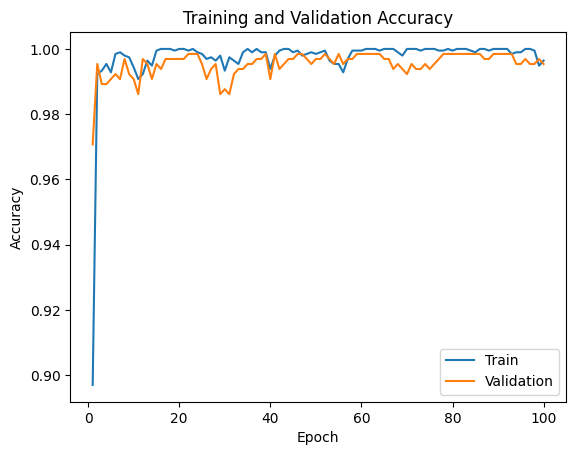

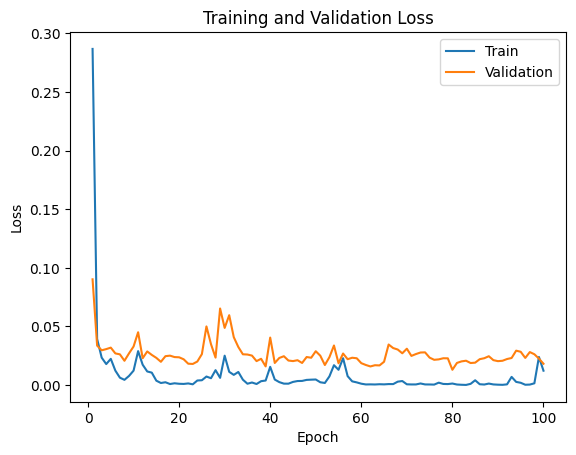

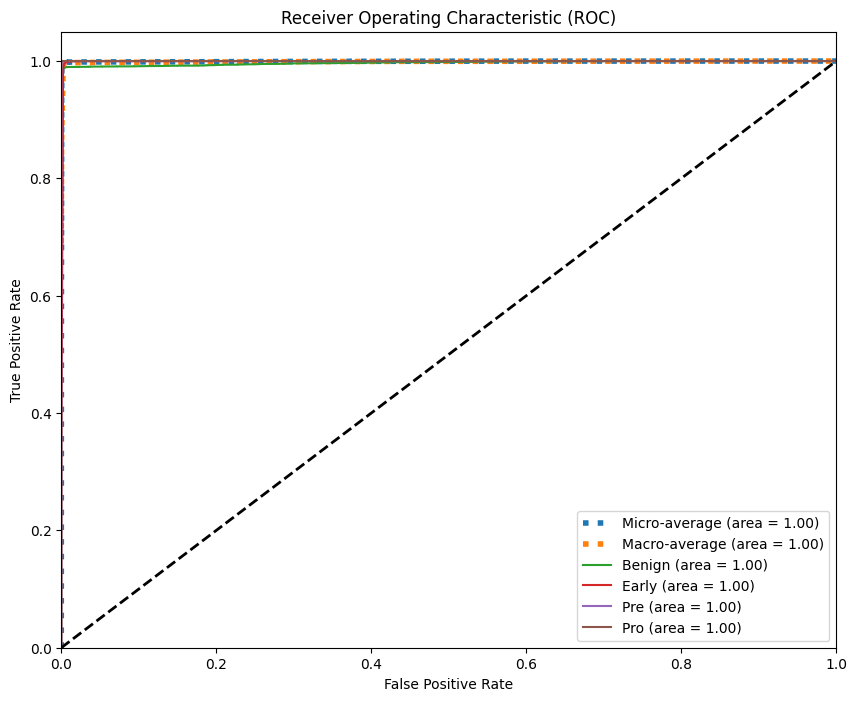

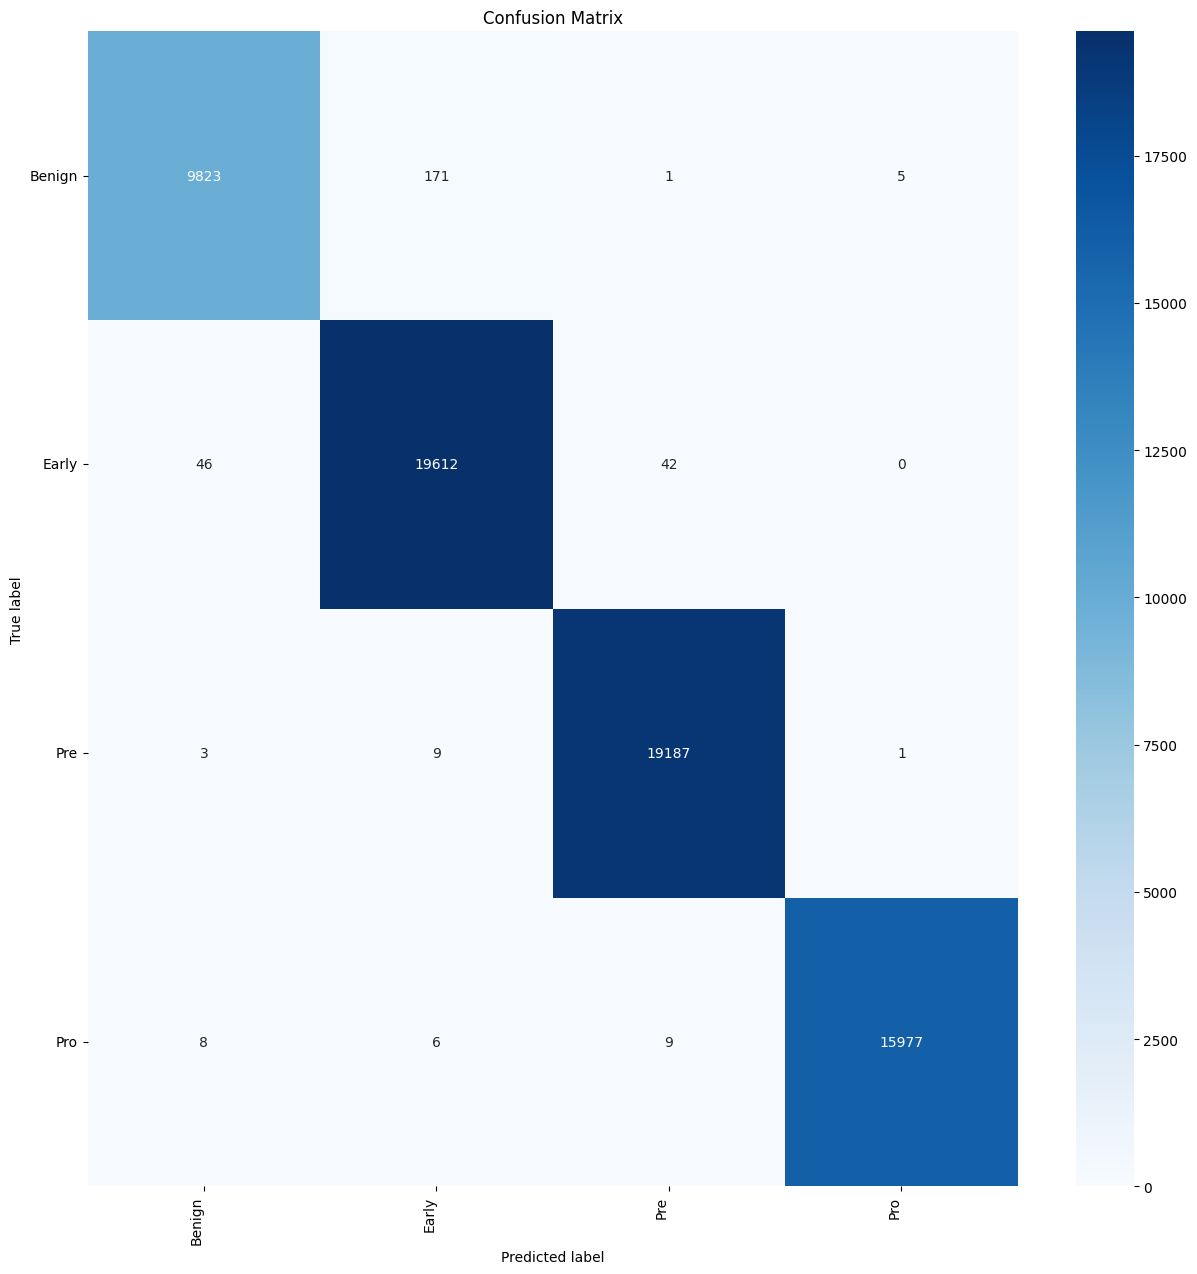

In [22]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler)

example = torch.rand(1, 3, 384, 384)
traced_script_module = torch.jit.trace(model.cpu(), example)
traced_script_module.save("/kaggle/working/ViT384_100epochs.pt")

In [24]:
import torch

model_path = "/kaggle/working/ViT384_100epochs.pt"
model = torch.jit.load(model_path)
model = model.to(device)

test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len

print('Test Loss: {:.{}f}'.format(test_loss, max(15, -int(np.log10(test_loss)) + 3)))

for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print('\nTest Accuracy : {:.4f} ({}/{})'.format(
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

100%|██████████| 21/21 [00:13<00:00,  1.61it/s]

Test Loss: 0.000001790159005
Test Accuracy of Benign: 100% (102/102)
Test Accuracy of Early: 100% (197/197)
Test Accuracy of   Pre: 100% (194/194)
Test Accuracy of   Pro: 100% (147/147)

Test Accuracy : 100.0000 (640/640)
